In [1]:
!pip install opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


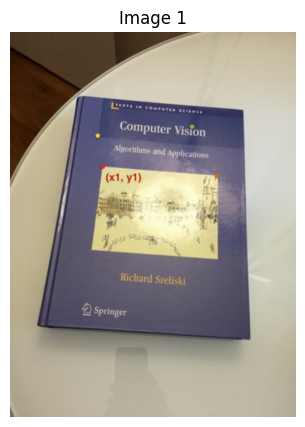

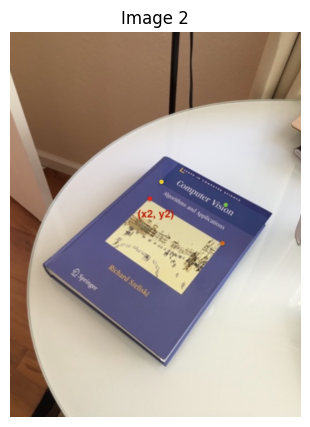

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two images
img1 = cv2.imread('/content/drive/MyDrive/programming/b1.png')
img2 = cv2.imread('/content/drive/MyDrive/programming/b2.png')

# Display image 1
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')
plt.show()

# Display image 2
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')
plt.show()

# Resize images to have the same height
# min_height = min(img1.shape[0], img2.shape[0])
# img1 = cv2.resize(img1, (int(img1.shape[1] * min_height / img1.shape[0]), min_height))
# img2 = cv2.resize(img2, (int(img2.shape[1] * min_height / img2.shape[0]), min_height))


### **ORB 特徵提取**
ORB（Oriented FAST and Rotated BRIEF）用於圖像特徵檢測和描述的演算法。ORB演算法結合了FAST（Features from Accelerated Segment Test）特徵檢測和BRIEF（Binary Robust Independent Elementary Features）描述符，同時添加了旋轉不變性。

* FAST特徵檢測：FAST是一種高速特徵檢測演算法，用於快速檢測圖像中的角點。它通過對像素周圍的圓形鄰域進行比較來識別角點。FAST演算法高效率，適用於實時應用，但對於旋轉、尺度和光照變化不具有不變性。

* BRIEF描述符：BRIEF是一種二進制描述符，用於描述檢測到的特徵點周圍的局部圖像區域。BRIEF描述符通過在特徵點周圍的像素對上應用隨機二進制測試來生成二進制字串。雖然計算速度快，但對於圖像的旋轉和尺度變化敏感。

* 旋轉不變性：ORB演算法通過引入方向賦予每個特徵點一個方向，使其具有旋轉不變性。這意味著即使圖像發生旋轉，ORB演算法仍然能夠正確地匹配特徵點。


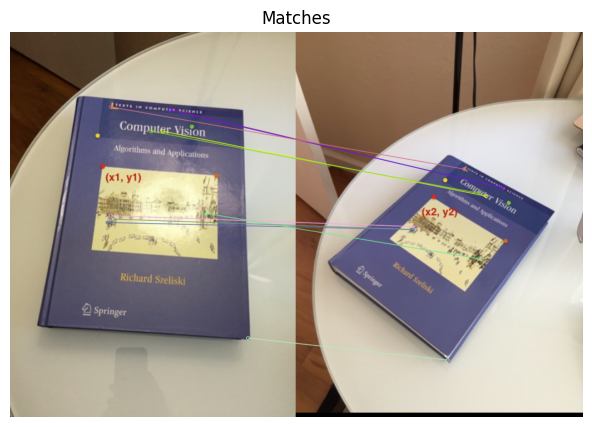

In [4]:
# Initiate ORB detector
orb = cv2.ORB_create()
# Find keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Matches')
plt.axis('off')
plt.show()


## **Homography**

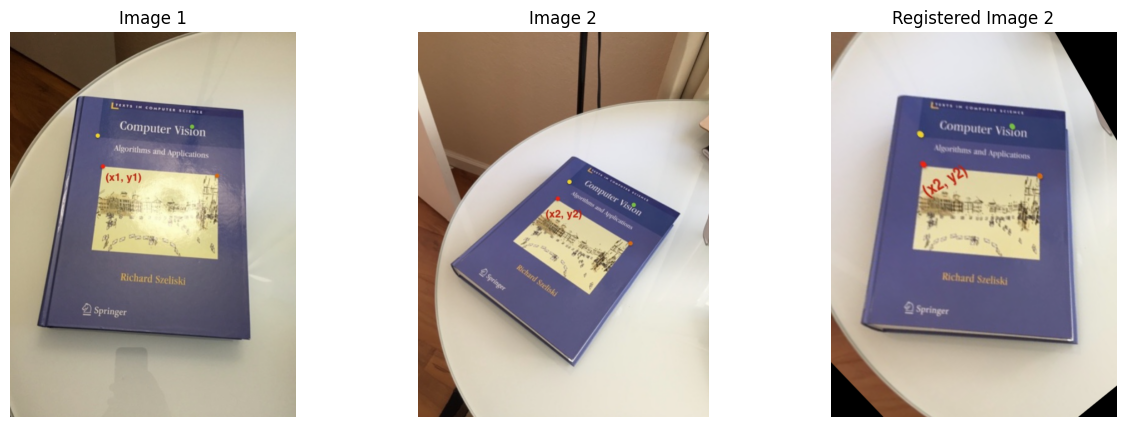

In [7]:
good_matches = matches[:10]  # Adjust the number of matches to use
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
img2_warped = cv2.warpPerspective(img2, M, (img1.shape[1], img1.shape[0]))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[0].set_title('Image 1')
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axs[1].set_title('Image 2')
axs[1].axis('off')

axs[2].imshow(cv2.cvtColor(img2_warped, cv2.COLOR_BGR2RGB))
axs[2].set_title('Registered Image 2')
axs[2].axis('off')

plt.show()

## code

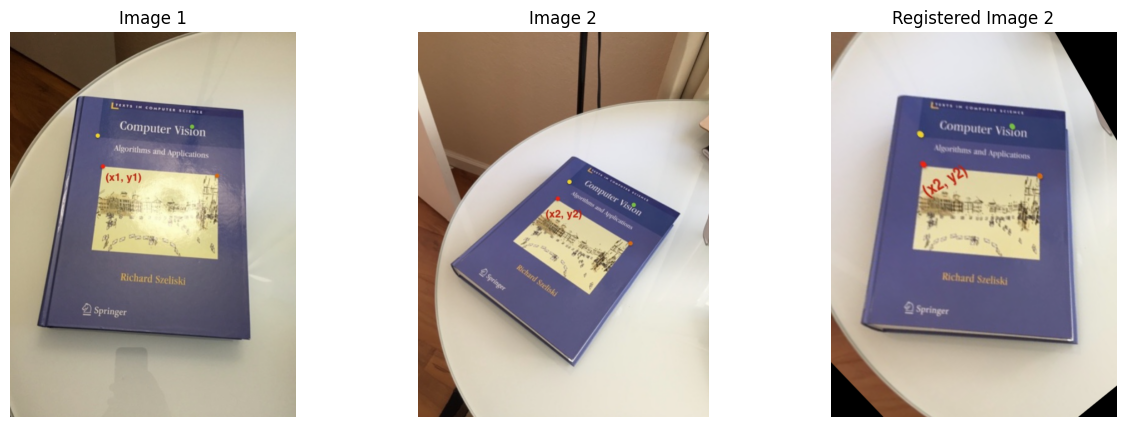

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Load images
    img1_path = '/content/drive/MyDrive/programming/b1.png'
    img2_path = '/content/drive/MyDrive/programming/b2.png'
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1 is None or img2 is None:
        print("Error: Can't load images")
        return

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors
    kp1, des1 = detect_and_describe(gray1)
    kp2, des2 = detect_and_describe(gray2)

    # Match features
    matches = match_features(des1, des2)

    # Find perspective transformation
    M = find_perspective_transform(kp1, kp2, matches)

    # Warp the second image
    img2_warped = cv2.warpPerspective(img2, M, (img1.shape[1], img1.shape[0]))

    # Display images
    display_images(img1, img2, img2_warped, M)

def detect_and_describe(image):
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(image, None)
    return kp, des

def match_features(des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def find_perspective_transform(kp1, kp2, matches):
    good_matches = matches[:10]  # Adjust the number of matches to use
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
    return M

def display_images(img1, img2, img2_warped, M):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Image 1')
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Image 2')
    axs[1].axis('off')

    axs[2].imshow(cv2.cvtColor(img2_warped, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Registered Image 2')
    axs[2].axis('off')

    plt.show()

if __name__ == "__main__":
    main()
